In [1]:
import sqlite3
import pandas as pd
import seaborn as sns

In [2]:
# Connect to the FellPace Database
db_file = "C:\\Users\\wired\\OneDrive\\Python projects\\FellPace\\fellpace.db"
con = sqlite3.connect(db_file)

To be able to effectively handicap we need to know the expected distribution of finish times for the Hallam Chase. We'll use everything up to the current year so that can  be used in testing.

In [3]:
# Have to create custom STD DEV function as not in SQL LITE
import math
class std_dev:
    def __init__(self):
        self.n = 0
        self.sum = 0
        self.sq = 0

    def step(self, value):
        self.n += 1
        self.sum += value
        self.sq += value * value

    def finalize(self):
        return math.sqrt(self.sq/self.n - (self.sum/self.n * self.sum/self.n )  )
con.create_aggregate('stddev',1,std_dev)

current_year = 2023

sql_extract =   'SELECT strftime("%Y",C.Chase_Date) as Year, avg(R.Time) as "Average Time", stddev(R.Time) as "STD Time", stddev(R.Handicap + R.Time) as "STD Handicap" FROM Results_Chase as R '\
                'JOIN Chases as C ON C.Chase_ID = R.Chase_ID '\
                'WHERE cast(Year as integer) < ? '\
                'GROUP BY Year'
Chase_Year_Data = pd.read_sql(sql_extract,con,params=(current_year,))

Expected_Time = Chase_Year_Data["Average Time"].mean()
Expected_STD = Chase_Year_Data["STD Time"].mean()


from IPython.display import display, HTML
display(HTML(Chase_Year_Data.to_html()))
print(f'The average finish time 2017 - {current_year-1} is: {Expected_Time: .2f}')
print(f'The expected standard deviation in finish, 2017 - {current_year-1} is: {Expected_STD: .2f}')

,Year,Average Time,STD Time,STD Handicap
0,2017,1962.232877,312.058280,117.941478
1,2018,1934.827586,298.204173,106.896874
2,2019,1967.428571,284.128113,126.549859
3,2021,1907.440678,301.453837,128.072783
4,2022,1933.421053,297.269973,118.917504


The average finish time 2017 - 2022 is:  1941.07
The expected standard deviation in finish, 2017 - 2022 is:  298.62


## Is Run Data Normal?
We wouldn't normally expect the run data to be normally distributed as there is a 'hard' limit at the low end of run times but no limit on maximum run time. 
How normal do they appear if we use kdeplot?

c:\Users\wired\anaconda3\envs\FellPace\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


,Time
Race,
Bakewell Pudding,0.443702
Bamford Carnival,NaN
Bamford Sheep Dog Trials,0.568334
Exterminator,NaN
Eyam Fell Race,0.939169
Grindleford,0.467551
Hathersage Gala,0.387745
Hope Wakes,0.296346
Parkrun_endcliffe,NaN


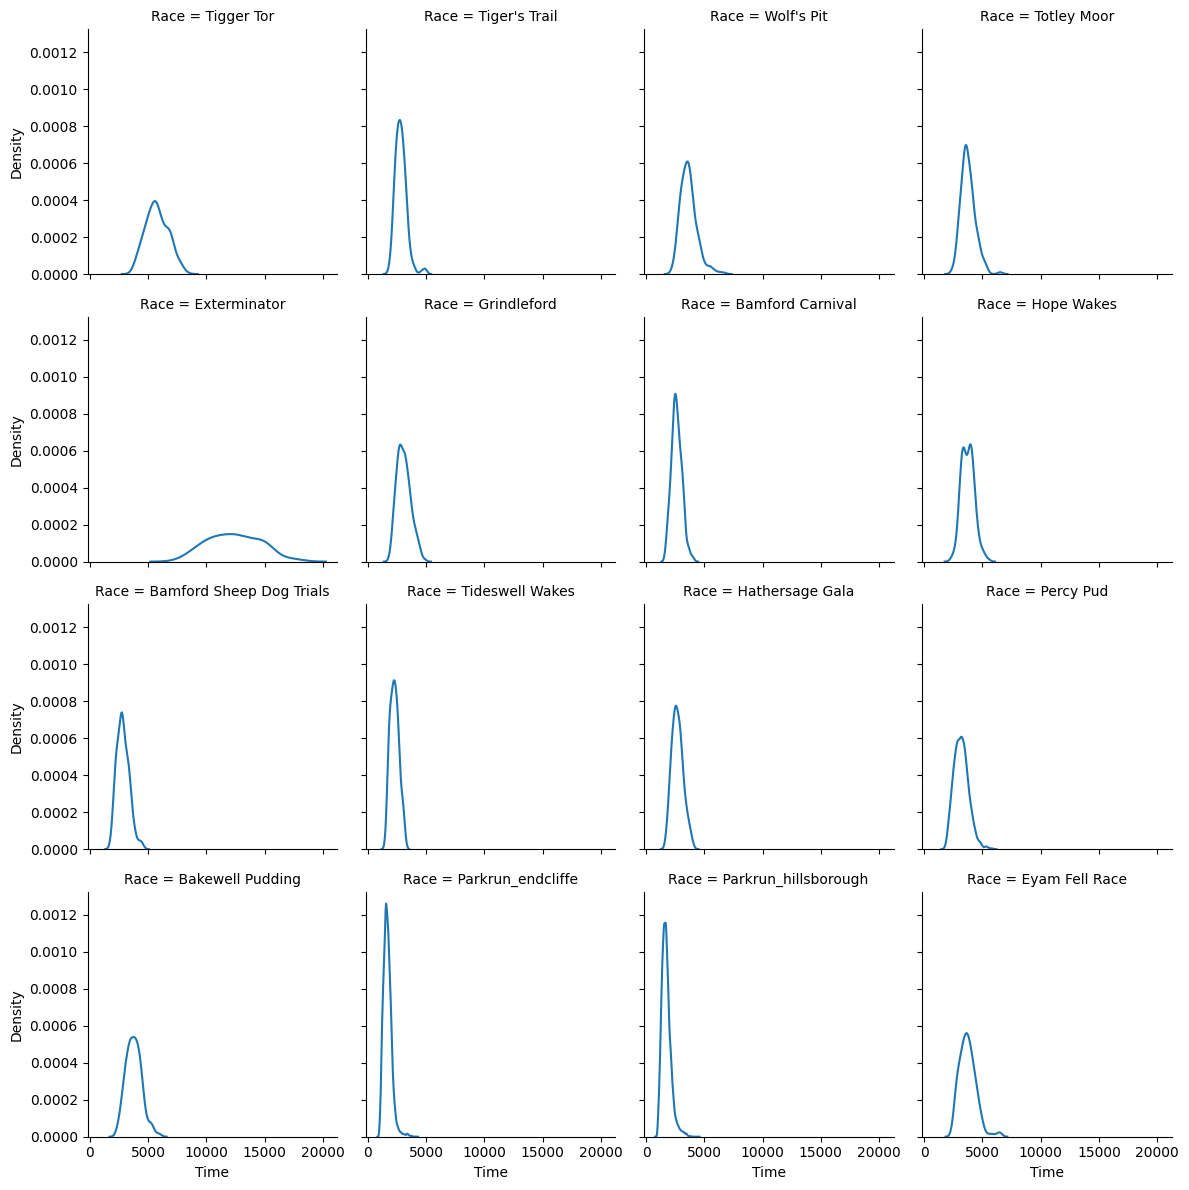

In [14]:
import numpy as np
query = '''
SELECT b.Time, a.Series_Name as Race
FROM Race_Series as a
LEFT JOIN (
    SELECT res.Time, rac.Series_ID as sID
    FROM Races as rac
    INNER JOIN Results as res
    ON rac.Race_ID = res.Race_ID
) as b
ON a.Series_ID = b.sID
'''

data_times = pd.read_sql(query,con)
g = sns.FacetGrid(data_times, col = "Race", col_wrap=4)
g.map(sns.kdeplot,'Time')
data_times.groupby('Race').aggregate(lambda x: sum( (x-np.mean(x))**3 )/ ( (len(x)-1 )*np.std(x)**3 ) )
                                     

We then need to establish what the 'Z Scores' for each runner is from races *other* than the Hallam Chase

In [4]:
#Get Zscores of runners from different events
import pandas as pd

sql_extract_zscore =    'SELECT R.Racer_Name, R.Racer_ID, C.Race_Name, min(RR.ZScore) as ZScore, AVG(RC.ZScore) as ChaseZ FROM Results as RR '\
                        'JOIN Racers as R '\
                        'ON RR.Racer_ID = R.Racer_ID '\
                        'JOIN Results_Chase as RC '\
                        'ON R.Racer_ID = RC.Racer_ID '\
                        'INNER JOIN (' \
                            'SELECT CASE ' \
                            'WHEN Race_Name LIKE "Parkrun_endcliffe%" THEN "PR_Endcliffe" ' \
                            'WHEN Race_Name LIKE "Parkrun_hillsborough%" THEN "PR_Hillsborough" ' \
                            'ELSE Race_Name ' \
                            'END            AS Race_Name, ' \
                            'Race_ID ' \
                            'FROM   Races ' \
                            ') as C '\
                        'ON C.Race_ID = RR.Race_ID '\
                        'WHERE R.Racer_ID IN (SELECT Racer_ID FROM Results_Chase) '\
                        'GROUP BY R.Racer_Name,C.Race_Name '\
                        'ORDER BY R.Racer_Name ASC'
from scipy.stats import zscore
data_Zs = pd.read_sql(sql_extract_zscore,con)

from IPython.display import display, HTML
import ipywidgets as widgets

def print_table(key):
    display(HTML(data_Zs[data_Zs['Racer_Name']==key].to_html()))

widgets.interact(print_table,key=data_Zs['Racer_Name'].unique())

interactive(children=(Dropdown(description='key', options=('Aaron Francis', 'Adelle Marsden', 'Al Cook', 'Alan…

<function __main__.print_table(key)>

It is important to establish how much data we have for the runners of the latest Hallam Chase, how many of the runners have run elsewhere?

In [9]:
# SQL Query to count the number of times the runners from 'current year' Hallam Chase appear in the overall results table
sql_query =     "SELECT Racers.Racer_Name as 'Racer Name', COUNT(Results.Result_ID) as Appearances "\
                "FROM Racers "\
                "LEFT JOIN Results ON Racers.Racer_ID = Results.Racer_ID "\
                "INNER JOIN     ("\
                "SELECT Racer_ID FROM Results_Chase "\
                "JOIN Chases ON Results_Chase.Chase_ID = Chases.Chase_ID "\
                "WHERE cast( strftime('%Y',Chases.Chase_Date) as integer) = ? "\
                ") as F ON F.Racer_ID = Racers.Racer_ID "\
                "GROUP BY Racers.Racer_Name"

data_for_racers = pd.read_sql(sql_query,con,params=(current_year,))
from IPython.display import display, HTML
display(HTML(data_for_racers.to_html()))
print(f'From {len(data_for_racers)} racers, {len(data_for_racers.loc[data_for_racers["Appearances"] == 0])} have no prior races in database')

,Racer Name,Appearances
0,Al Cook,1
1,Alan Chapman,65
2,Andy Horsfall,7
3,Ben Burrell,32
4,Ben Jones,14
5,Ben Moon,13
6,Chris Horsfall,7
7,Chris Ireland,1
8,Chris Reece,10
9,Connor Smith,1


From 62 racers, 10 have no prior races in database


Now, we can create models for all runner data *prior* to the current year. For the sake of simplicity though, we'll use all the prior race data, even if the race occured *after* the latest Hallam Chase, if nothing more because we haven't got that much data!
First thing, get rid of racers that were in the latest Hallam chase

In [30]:
sql_query = "SELECT Racer_ID FROM Results_Chase "\
            "JOIN Chases ON Results_Chase.Chase_ID = Chases.Chase_ID "\
            "WHERE cast( strftime('%Y',Chases.Chase_Date) as integer) = ?"\

latest_chasers = pd.read_sql(sql_query,con,params=(current_year,))

data_Zs = pd.read_sql(sql_extract_zscore,con)

data_Zs_all = data_Zs #Create full table before restricting

data_Zs_latest = data_Zs.merge(latest_chasers,on="Racer_ID",how="left",indicator=True) \
    .query("_merge == 'both'") \
    .drop("_merge", axis = 1)

data_Zs = data_Zs.merge(latest_chasers,on="Racer_ID",how="left",indicator=True)\
        .query("_merge == 'left_only'")\
        .drop("_merge", axis = 1)


print(f'There were {len(data_Zs_all)} racers but after exclusion there are {len(data_Zs)}')
print(f'There are {len(data_Zs_latest)} racers in the latest group')

There were 409 racers but after exclusion there are 235
There are 174 racers in the latest group


Next, we'll do some simple cleaning. Assuming an x = y model, we can look at the distribution of the data and exclude outliers -- sometimes someone won't be racing to their ability and this can skew models.

<Axes: xlabel='ZoCZ', ylabel='Race_Name'>

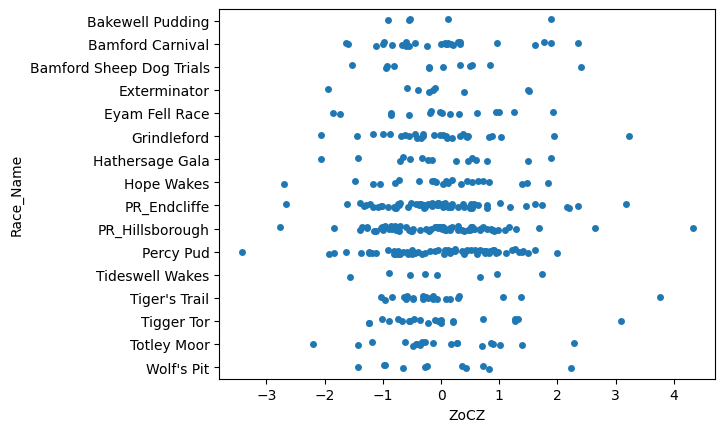

In [10]:
# Could we exclude plots based on a transformation along the X=Y so sqrt(2)/2
import math
from scipy import stats

a = math.sqrt(2)/2
data_Zs["ZoC"] = data_Zs["ZScore"]*a - data_Zs["ChaseZ"] * a

def get_zscore(group):
    group["ZoCZ"] = stats.zscore(group["ZoC"])
    return group

data_Zs = data_Zs.groupby("Race_Name",as_index=False, group_keys=True).apply(get_zscore)
data_Zs.drop(columns=["ZoC"])
#Strip out records where Z is above 3
data_Zs_clean = data_Zs.loc[abs(data_Zs["ZoCZ"]) <=2.5]

sb.stripplot(data_Zs,x="ZoCZ",y="Race_Name")

c:\Users\wired\anaconda3\envs\FellPace\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\wired\anaconda3\envs\FellPace\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


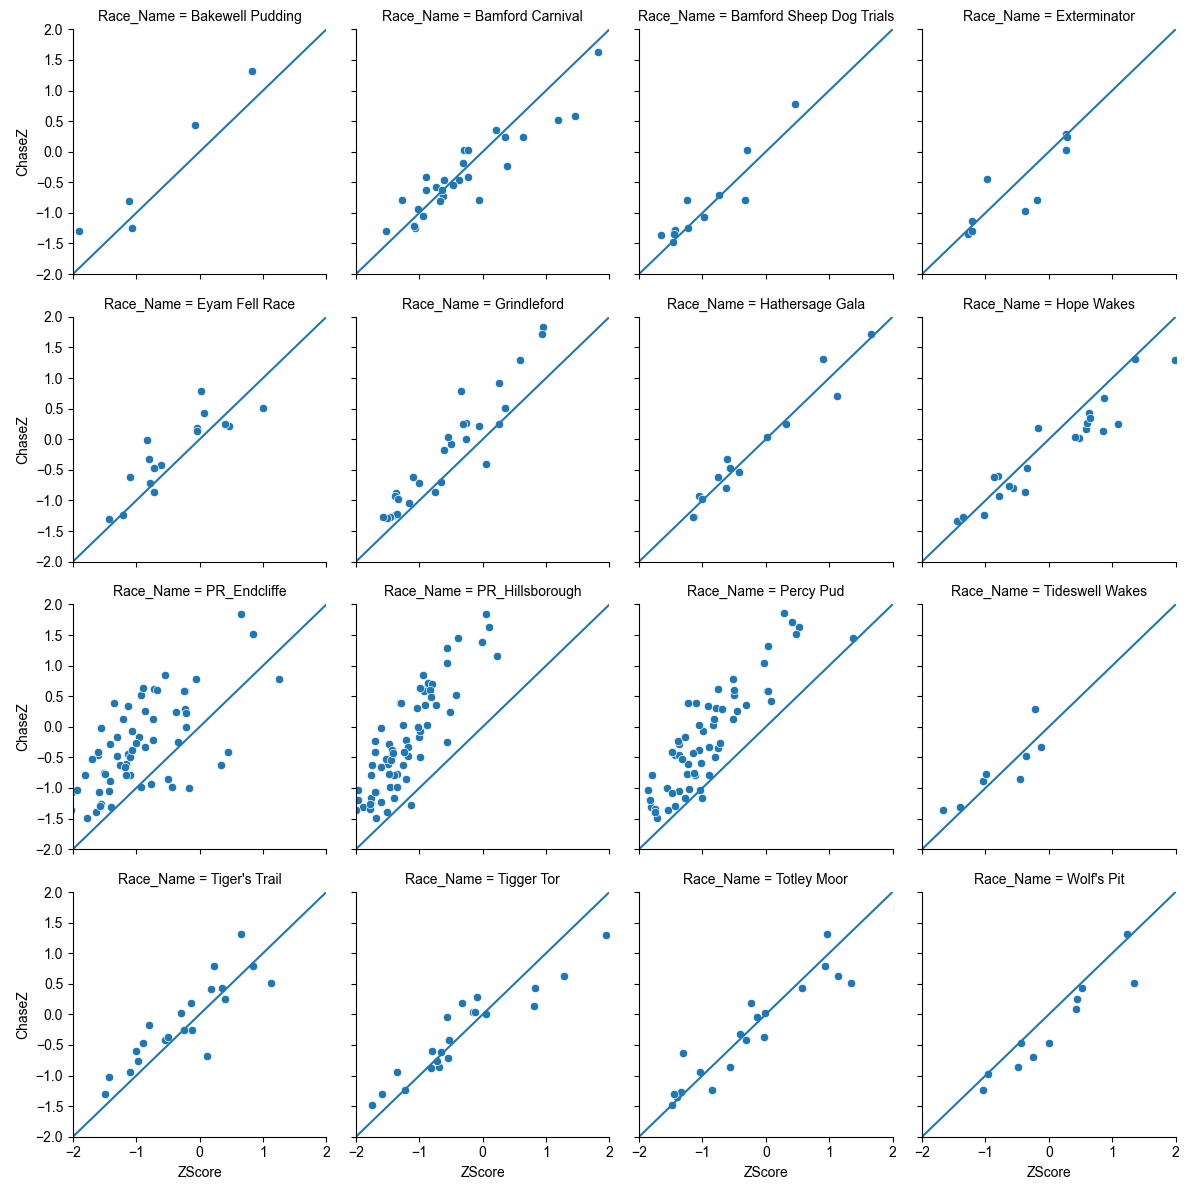

In [11]:
# Some Plots
g = sb.FacetGrid(data_Zs_clean, col = "Race_Name", col_wrap=4,xlim=(-2,2),ylim=(-2,2))
g.map(sb.scatterplot,"ZScore","ChaseZ")
def xy_line(*args, **kwargs):
    import matplotlib.pyplot as mpp
    x = [-2, 2]
    y = [-2, 2]
    mpp.plot(y, x)

g.map(xy_line)
sb.set_theme()

In [40]:
# Get linear models for each race, present coefficients in a table so can correct Zscore between races
from sklearn.linear_model import LinearRegression
def calculate_linear_model(group):
     model = LinearRegression().fit(group["ZScore"].values.reshape(-1,1),group["ChaseZ"].values)
     group['ModelZ'] = model.predict(group["ZScore"].values.reshape(-1,1))
     return model
Z_models = data_Zs_clean[["Race_Name","ZScore","ChaseZ"]].groupby("Race_Name").apply(calculate_linear_model)
models_d = Z_models.to_dict()


{'Bakewell Pudding': LinearRegression(), 'Bamford Carnival': LinearRegression(), 'Bamford Sheep Dog Trials': LinearRegression(), 'Exterminator': LinearRegression(), 'Grindleford': LinearRegression(), 'Hathersage Gala': LinearRegression(), 'Hope Wakes': LinearRegression(), 'PR_Endcliffe': LinearRegression(), 'PR_Hillsborough': LinearRegression(), 'Percy Pud': LinearRegression(), 'Tideswell Wakes': LinearRegression(), "Tiger's Trail": LinearRegression(), 'Tigger Tor': LinearRegression(), 'Totley Moor': LinearRegression(), "Wolf's Pit": LinearRegression()}


We now have a model for each race, we can apply this model to the latest racers to predict their ZScore for the Hallam Chase

In [60]:
def apply_model(group):
    race = group["Race_Name"].values[0]
    model = models_d[race]
    group["Predicted_Z"] = model.predict(group["ZScore"].values.reshape(-1,1))
    return group

data_Zs_latest = data_Zs_latest.groupby("Race_Name").apply(apply_model)
from IPython.display import display, HTML
display(HTML(data_Zs_latest.to_html()))

C:\Users\wired\AppData\Local\Temp\ipykernel_10728\3689912173.py:7: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  data_Zs_latest = data_Zs_latest.groupby("Race_Name").apply(apply_model)


,Racer_Name,Racer_ID,Race_Name,ZScore,ChaseZ,Predicted_Z
6,Al Cook,1290,Bamford Carnival,-0.627974,-0.727020,-0.595478
7,Alan Chapman,3011,PR_Hillsborough,-0.567410,1.039320,0.612359
8,Alan Chapman,3011,Percy Pud,-0.024248,1.039320,0.721444
33,Andy Horsfall,728,Bakewell Pudding,0.826089,1.318454,-0.419856
34,Andy Horsfall,728,Hathersage Gala,0.903531,1.318454,0.649470
35,Andy Horsfall,728,Hope Wakes,1.359749,1.318454,0.732596
36,Andy Horsfall,728,Percy Pud,0.037880,1.318454,0.786230
37,Andy Horsfall,728,Tiger's Trail,0.652460,1.318454,0.367074
38,Andy Horsfall,728,Totley Moor,0.971067,1.318454,0.424946
39,Andy Horsfall,728,Wolf's Pit,1.226564,1.318454,0.578137


C:\Users\wired\anaconda3\envs\FellPace_Jupyter\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


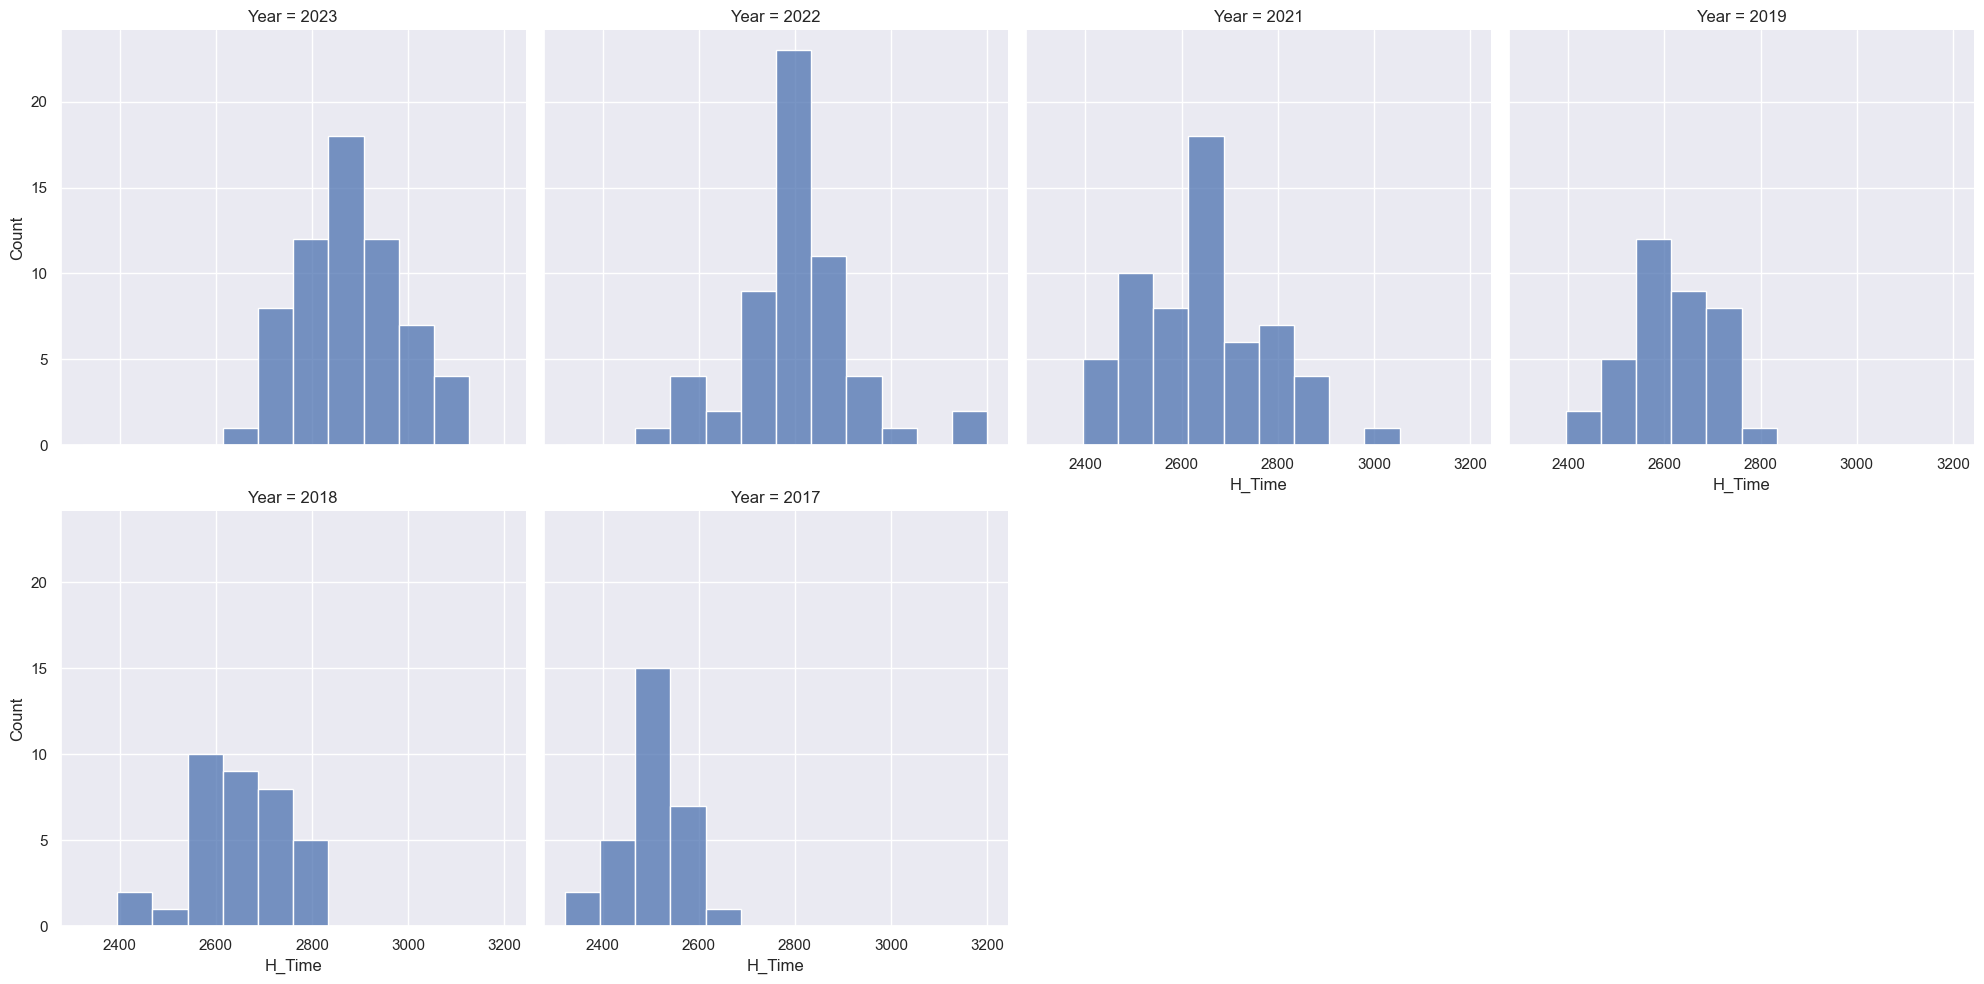

In [21]:
sql_extract =   'Select R.Racer_Name, RC.Time as Time,RC.Time + RC.Handicap as H_Time, strftime("%Y",C.Chase_Date) as Year  FROM Results_Chase as RC ' \
                'INNER JOIN Racers as R ' \
                'ON RC.Racer_ID = R.Racer_ID ' \
                'INNER JOIN Chases as C ' \
                'ON C.Chase_ID = RC.Chase_ID '

data_chase = pd.read_sql(sql_extract,con)
sb.displot(data = data_chase,x="H_Time",col="Year",col_wrap=4)

In [15]:
from math import floor
import ipywidgets as widgets
Races = pd.read_sql('SELECT Race_Name, Race_Date FROM Races',con)
Races['KEYS'] = Races['Race_Name'] + ' ' + Races['Race_Date']
opts = []

def time_formatter(x_val):
    hrs = int(floor(x_val/3600))
    mins = int(floor((x_val%3600) /60))
    secs = int(x_val % 60)
    if hrs >0:
        return f"{hrs:02d}:{mins:02d}:{secs:02d}"
    else:
        return f"{mins:02d}:{secs:02d}"

#query to get data
query = 'SELECT Time FROM Results as RR '\
        'INNER JOIN Races as R '\
        'ON RR.Race_ID = R.Race_ID '\
        'WHERE R.Race_Name = ? '\
        'AND R.Race_Date = ?'
def plot_dist(key):
    i = Races.index[Races['KEYS'] == key].tolist()[0]
    Name = Races['Race_Name'].iloc[i]
    Date = Races['Race_Date'].iloc[i]
    data = pd.read_sql(query,con,params=(Name,Date))
    plt = sns.histplot(data['Time'])

    xlabels = [time_formatter(x) for x in plt.get_xticks()]
    plt.set_xticklabels(xlabels)

widgets.interact(plot_dist,key = Races['KEYS'])

interactive(children=(Dropdown(description='key', options=('Tigger Tor 2023-01-29', "Tiger's Trail 2023-04-26"…

<function __main__.plot_dist(key)>